# Contrastive Language-Image Pretraining (CLIP)

Today, we will delve into the intersection of computer vision and natural language processing, which has gained significant importance in recent times. The development of robust vision and language models has been crucial in enabling this intersection.

CLIP [1] is a noteworthy example of such a model. It has the capability to comprehend natural language descriptions of images and generate image embeddings that can cater to a range of downstream tasks. The model has been trained on a vast dataset of images and their corresponding captions, which has facilitated it to acquire a comprehensive representation of both images and language.

## Setup

Let's start with the installation of the necessary packages.

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gyr4otpj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gyr4otpj
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


We can now import all the pertinent packages.

In [2]:
import numpy as np
import torch
import torchvision

from clip import clip

First, we can visualise the available pre-trained models...

In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

...and load one of them. For this, we can use the `clip.load()` function and specify the name of the model we want to use.

In [4]:
model, preprocess = clip.load("RN50")
model = model.cuda().eval()

By inspecting some variables, we can better understand the structure of the architecture we loaded.

In [5]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


## Zero-shot evaluation

CLIP's extraordinary feature is its zero-shot capability, which enables it to perform tasks without any additional training or fine-tuning on specific datasets.

This ability is made possible by CLIP's pre-training on a large corpus of text and images, which empowers it to acquire a comprehensive and flexible representation of language and visual concepts. Consequently, CLIP can perform an extensive range of tasks without any additional training, making it a powerful tool for various applications in NLP and computer vision.

To assess this capability, we need to prepare some test samples. Earlier, by employing the `clip.load()` function, we obtained two outputs—the pre-trained CLIP model and a preprocess object. On examining the object, we can infer that it contains a list of transformations to apply on input images to make them compatible with the model.

In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f81821e9440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

Therefore, we can use the `preprocess` transform to convert `PIL.Image`s into tensors that are compatible with CLIP.

However, for the textual counterpart, we cannot apply the same transformation. Instead, we can use the `clip.tokenize()` function, which accepts textual input and converts it into an integer tensor.

In [7]:
clip.tokenize("tokenize me!")

tensor([[49406, 32634, 10885,   614,   256, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

We will now examine CLIP's performance on a set of images and textual descriptions.

Before proceeding, let's import additional packages that we would require to use. Furthermore, we can use some iPython magics to enhance the visualisation.

In [8]:
from collections import OrderedDict
from pathlib import Path

import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Next, we can define a list of images that we plan to test and also visualize them along with their textual descriptions.

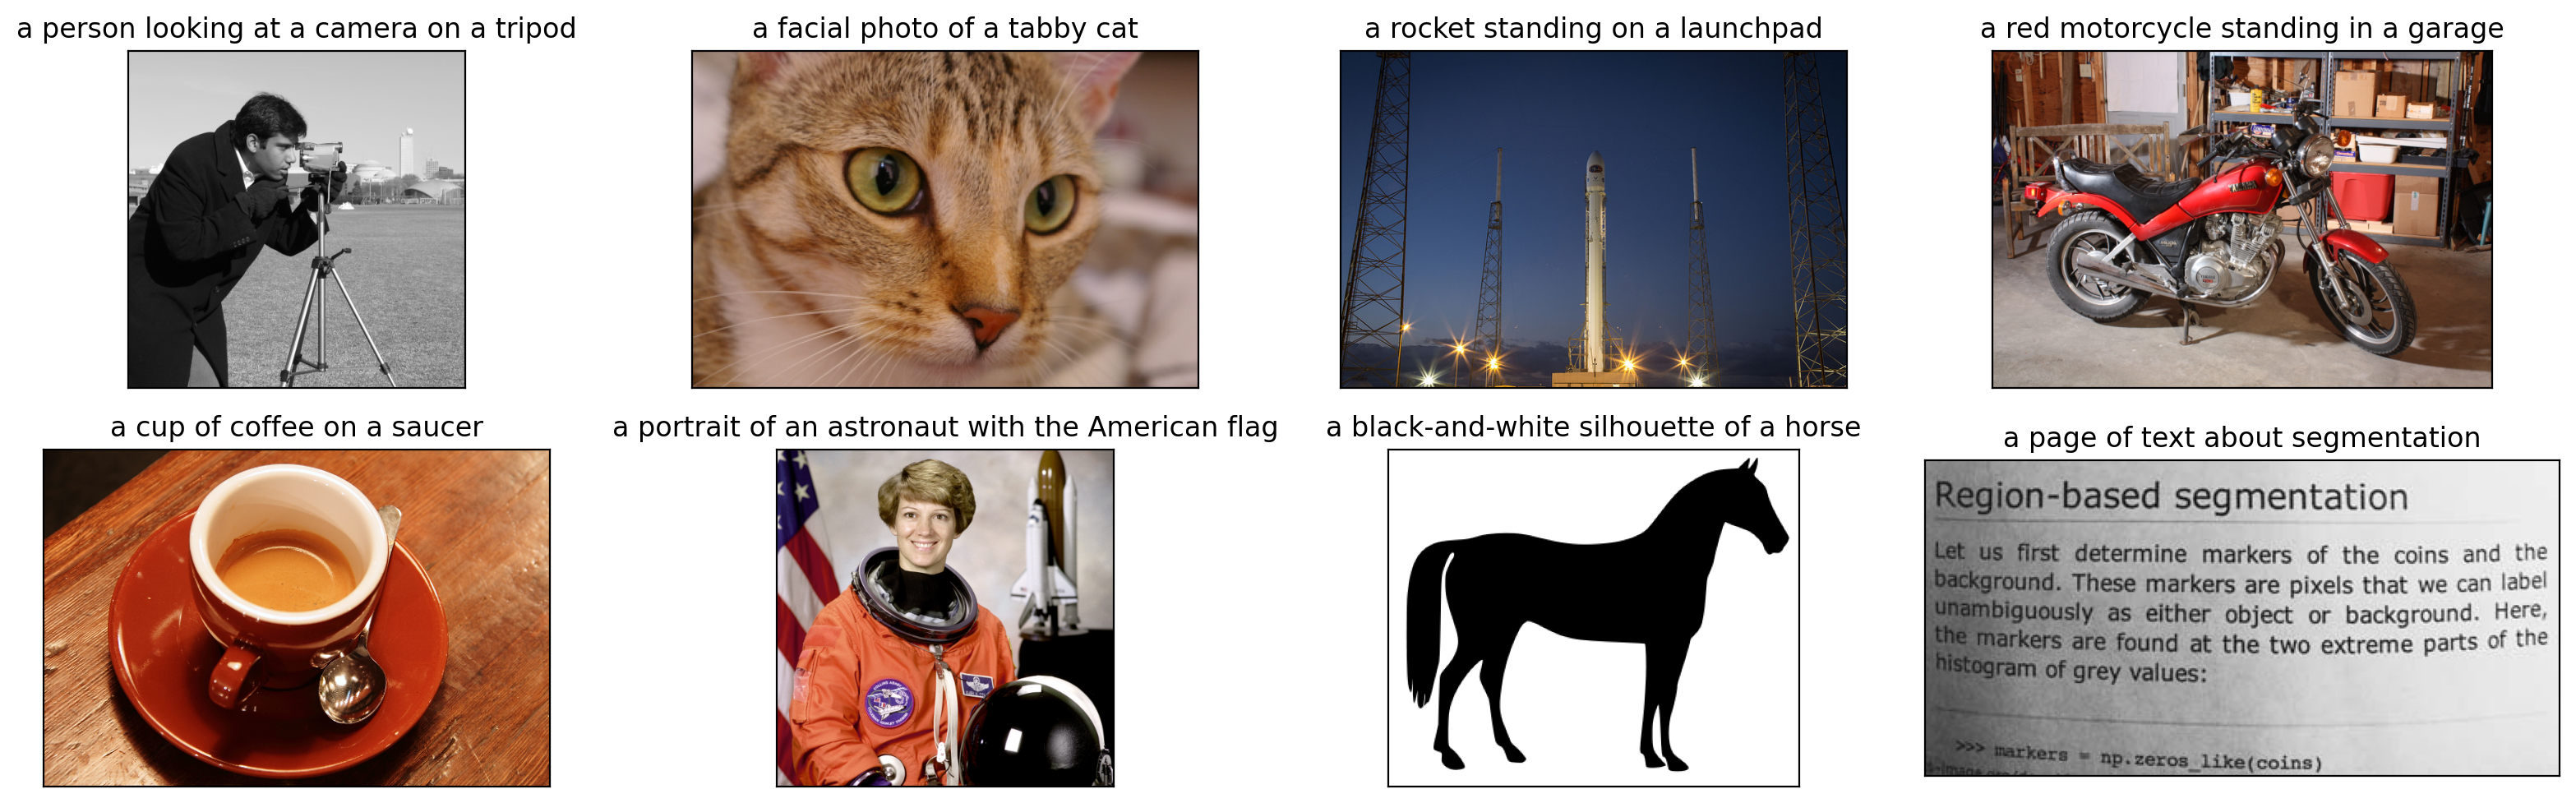

In [9]:
# create a description for some images
DESCRIPTIONS = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

def get_data():
  images = []
  texts = []

  # get all the filenams in the data directory
  data_dir = Path(skimage.data_dir)
  filenames = [
    filename for filename in data_dir.glob('*')
    if filename.suffix in {'.png', '.jpg'}
  ]

  for filename in filenames:
    # skip images we do not care about
    name = filename.stem
    if name not in DESCRIPTIONS:
        continue

    # store data
    images.append(filename)
    texts.append(DESCRIPTIONS[name])

  return images, texts

def visualise_data(images_fp: list[str], texts: list[str]):
  # create a matplotlib figure object
  plt.figure(figsize=(16, 5))

  for i, (image_fp, text) in enumerate(zip(images_fp, texts)):
    # open the images
    image = Image.open(image_fp).convert("RGB")

    # visualise the image
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(text)
    plt.xticks([])
    plt.yticks([])
  plt.tight_layout()

images_fp, texts = get_data()
visualise_data(images_fp, texts)

To obtain the features of the images, we need to preprocess them using the methods that we discussed previously.

In [10]:
def encode_data(images_fp: list[str], texts: list[str]):
  # preprocess the images to transform from filenames to images to tensors
  images = [preprocess(Image.open(image)) for image in images_fp]

  # preprocess the texts to transform from text to tensors
  images = torch.tensor(np.stack(images)).cuda()
  text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

  # encode the inputs
  with torch.no_grad():
    images_z = model.encode_image(images).float()
    texts_z = model.encode_text(text_tokens).float()

  return images_z, texts_z

We can now evaluate the similarity between the set of images and the set of textual descriptions that we created. We can expect that the similarity will be higher for the pairs that we plotted earlier.

Initially, **it is vital** to normalize the features to make them "compatible" and facilitate reasoning in the feature space.

In [11]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

images_fp, texts = get_data()
images_z, texts_z = encode_data(images_fp, texts)
similarity = cosine_similarity(images_z, texts_z)
print(similarity)

tensor([[0.2396, 0.1672, 0.1319, 0.0815, 0.1225, 0.1297, 0.1410, 0.1260],
        [0.1153, 0.2614, 0.0917, 0.0716, 0.1369, 0.1454, 0.1205, 0.1319],
        [0.1807, 0.1459, 0.2360, 0.1193, 0.1040, 0.1655, 0.1247, 0.1113],
        [0.0484, 0.0921, 0.0485, 0.2701, 0.0841, 0.1017, 0.1142, 0.0544],
        [0.1126, 0.1353, 0.0699, 0.0833, 0.2437, 0.1114, 0.1095, 0.1171],
        [0.1435, 0.0977, 0.1550, 0.0738, 0.0867, 0.2298, 0.1075, 0.0752],
        [0.1556, 0.0760, 0.0775, 0.0628, 0.1069, 0.0758, 0.2969, 0.1525],
        [0.1195, 0.1454, 0.1037, 0.0796, 0.1397, 0.1019, 0.1415, 0.2772]])


As anticipated, the similarity is higher on the diagonal, i.e., for the pairs that we defined earlier. We can also visualize these values to make it more explicit.

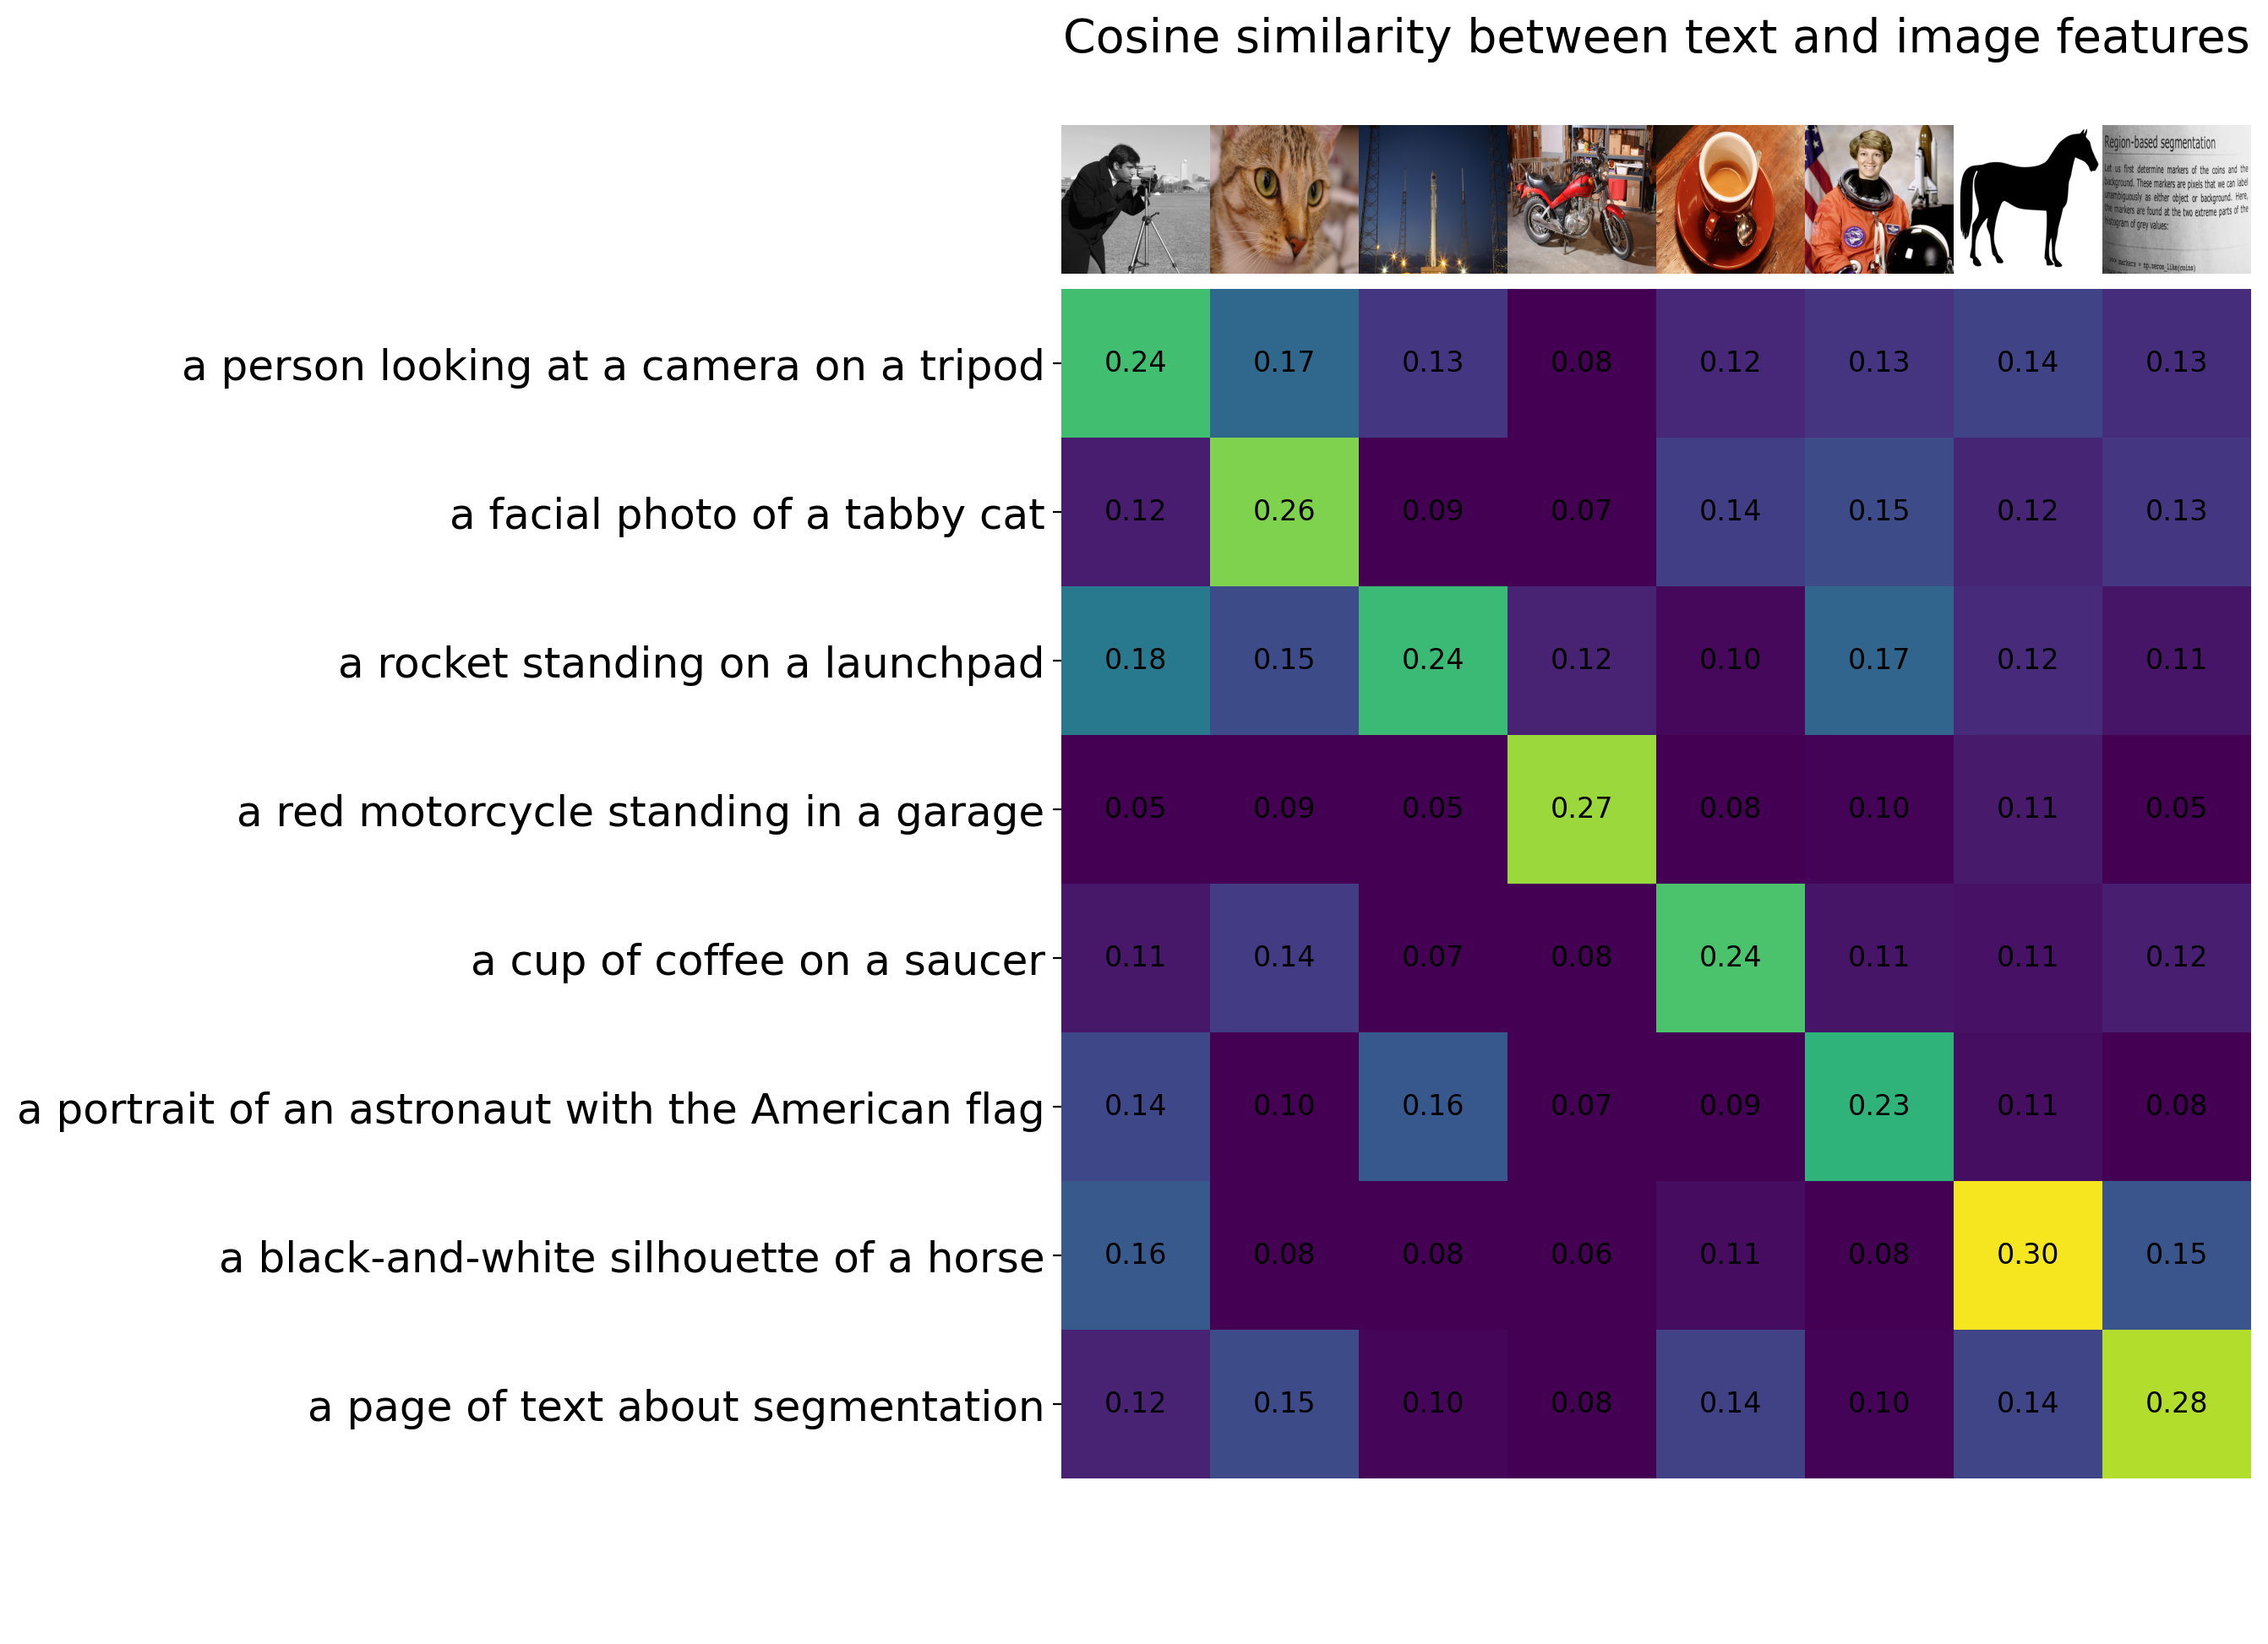

In [12]:
def visualise_similarity(similarity: torch.Tensor, images_fp: list[str], texts: list[str]):
  similarity = similarity.numpy()
  count = len(texts)

  # create a matplotlib figure object
  plt.figure(figsize=(18, 12))

  # show similarity scores
  plt.imshow(similarity, vmin=0.1, vmax=0.3)

  # update plot ticks
  plt.yticks(range(count), texts, fontsize=18)
  plt.xticks([])

  # visualise each image
  for i, image_fp in enumerate(images_fp):
    image = Image.open(image_fp).convert("RGB")
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

  # print the scores
  for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
      plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  # update spines
  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  # change plot limits
  plt.xlim([-0.5, count - 0.5])
  plt.ylim([count + 0.5, -2])

  # set title
  plt.title("Cosine similarity between text and image features", size=20)

visualise_similarity(similarity, images_fp, texts)

It is evident that these scores provide valuable information, which could also be used for a classification task. For instance, consider the scenario where instead of descriptions such as "a cup of coffee on a saucer," we had descriptions such as "a photo of a mug," "a photo of a horse," and "a photo of a person." These three descriptions can effectively enable us to identify whether the image contains a mug, a horse, or a person.

This highlights the potent zero-shot capabilities of CLIP, as it enables us to classify any image by simply creating a list of objects of interest and converting them into textual descriptions or prompts. By subsequently comparing these descriptions with the image and collecting similarity scores, we can directly classify an image as a mug if the score for the mug is the highest in the description set.

Let's explore this further with an example on CIFAR10.

Files already downloaded and verified


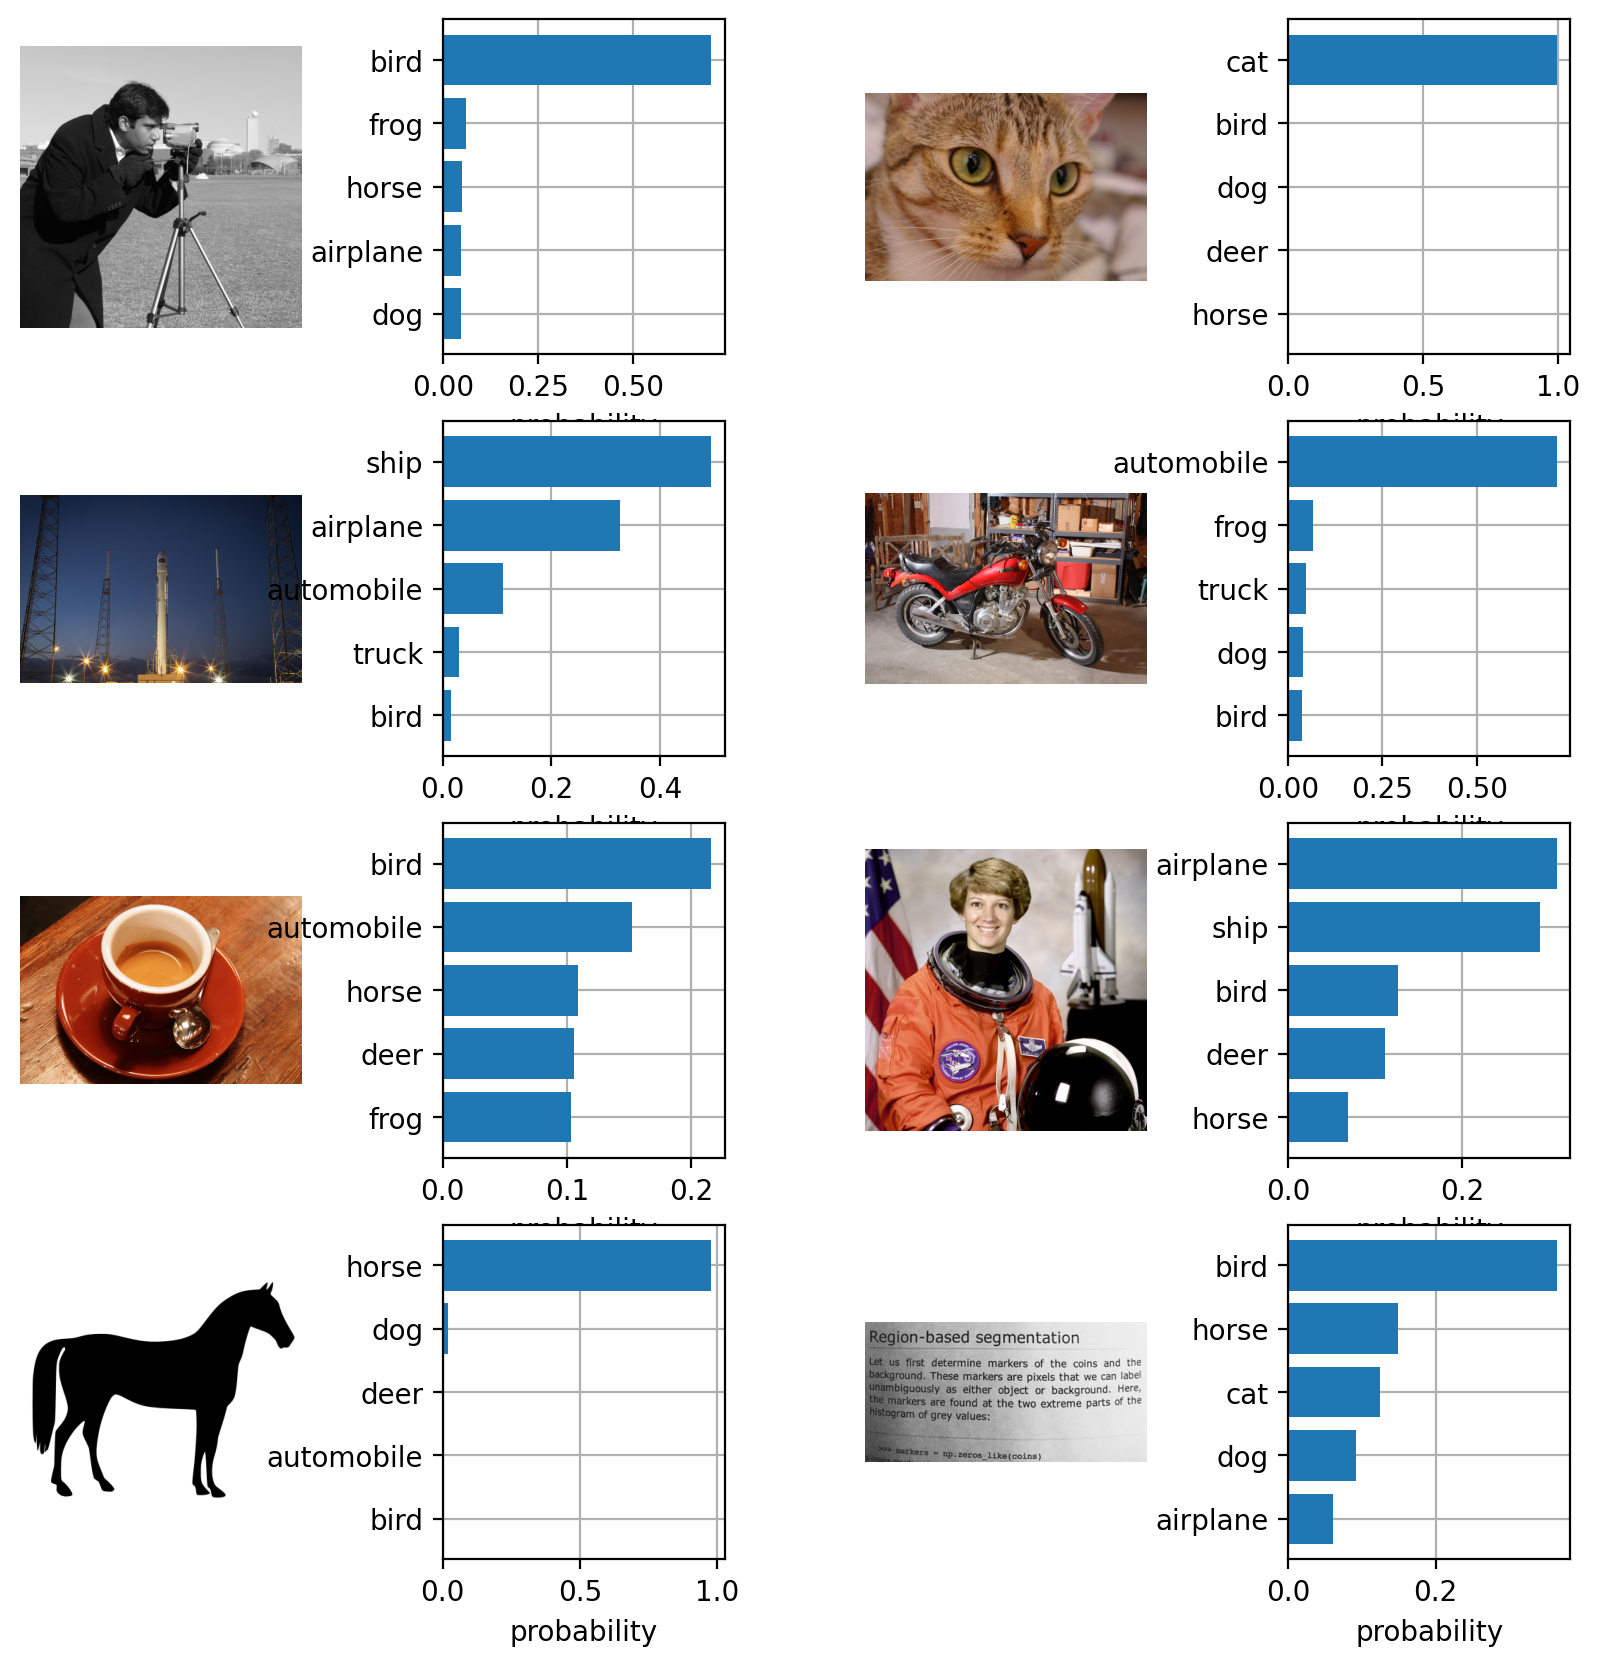

In [13]:
DATASETS = {
    #"mnist": torchvision.datasets.MNIST,
    "cifar10": torchvision.datasets.CIFAR10,
    #"cifar100": torchvision.datasets.CIFAR100,
}

def embed_dataset_classnames(dataset_name: str):
  Dataset = DATASETS[dataset_name]

  # create the list of descriptions and tokenise them
  dataset = Dataset("./data", transform=preprocess, download=True, train=False)
  classnames = dataset.classes
  descriptions = [f"a photo of a {label}." for label in classnames]
  text_tokens = clip.tokenize(descriptions).cuda()

  # get the normalised textual features
  with torch.no_grad():
      texts_z = model.encode_text(text_tokens).float()
      texts_z /= texts_z.norm(dim=-1, keepdim=True)

  return classnames, texts_z

def visualise_probabilities(
    images_fp: list[str], classnames: list[str], texts_p: torch.Tensor, k: int = 5
  ):
  topk_p, topk_labels = texts_p.cpu().topk(k, dim=-1)
  # create a matplotlib figure object
  plt.figure(figsize=(10, 10))

  for i, image_fp in enumerate(images_fp):
    # read the image
    image = Image.open(image_fp).convert("RGB")

    # visualise the image
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    # visualise the probabilties for the image
    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(topk_p.shape[-1])
    plt.grid()
    plt.barh(y, topk_p[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classnames[index] for index in topk_labels[i].numpy()])
    plt.xlabel("probability")

  plt.subplots_adjust(wspace=0.5)
  plt.show()


# get the text descriptions and their embeddings
texts, texts_z = embed_dataset_classnames("cifar10")

# evalaute the softmax from the cosine similarities
similarity = cosine_similarity(texts_z, images_z)
texts_p = (100 * similarity).softmax(dim=-1)

# visualise the similarity
# visualise_similarity(similarity, images_fp, texts)

# visualise the top-5 predictions
visualise_probabilities(images_fp, texts, texts_p, k=5)

It is noteworthy that the list of descriptions functions as if they were a classifier. Until now, we have observed and trained neural networks that can generally be broken down into an encoder network and a classifier network. However, as we saw in the last lab, if we have to adapt a pre-trained neural network for another task, we have to drop the classifier and retrain it from scratch.

But, by design, CLIP has no classifier and can classify by merely changing the list of textual descriptions we use. Therefore, the list of textual descriptions can also be considered a flexible classifier.

## Some considerations

Thus far, we employed textual descriptions to classify images. However, the opposite can also be accomplished. What we did so far was compare an image with a list of textual descriptions and select the most similar text for that image. But, we can also do the exact opposite.

This type of application may be useful in other scenarios, but it is merely an idea of what you can achieve by reasoning with the components you possess. Another example is that you can compare the similarity between images and images or between text and text to comprehend their degree of similarity.

In [14]:
# compare how text is similar to other text
similarity = cosine_similarity(texts_z, texts_z)
print(similarity)

# compare how images are similar one with the other
similarity = cosine_similarity(images_z, images_z)
print(similarity)

tensor([[1.0000, 0.8933, 0.8919, 0.8693, 0.8201, 0.8780, 0.7962, 0.8647, 0.8943,
         0.8745],
        [0.8933, 1.0000, 0.8733, 0.8680, 0.8074, 0.8790, 0.7816, 0.8646, 0.8848,
         0.9218],
        [0.8919, 0.8733, 1.0000, 0.9138, 0.8642, 0.9087, 0.8556, 0.8966, 0.8719,
         0.8591],
        [0.8693, 0.8680, 0.9138, 1.0000, 0.8574, 0.9309, 0.8336, 0.8914, 0.8564,
         0.8521],
        [0.8201, 0.8074, 0.8642, 0.8574, 1.0000, 0.8743, 0.8131, 0.8642, 0.8136,
         0.8101],
        [0.8780, 0.8790, 0.9087, 0.9309, 0.8743, 1.0000, 0.8525, 0.9151, 0.8627,
         0.8727],
        [0.7962, 0.7816, 0.8556, 0.8336, 0.8131, 0.8525, 1.0000, 0.8282, 0.7825,
         0.7851],
        [0.8647, 0.8646, 0.8966, 0.8914, 0.8642, 0.9151, 0.8282, 1.0000, 0.8570,
         0.8567],
        [0.8943, 0.8848, 0.8719, 0.8564, 0.8136, 0.8627, 0.7825, 0.8570, 1.0000,
         0.8790],
        [0.8745, 0.9218, 0.8591, 0.8521, 0.8101, 0.8727, 0.7851, 0.8567, 0.8790,
         1.0000]])
tensor([[

Furthermore, until now, we considered only a single "prompt" for each class name (i.e., "a photo of a [CLS]"), but we can use multiple templates to generate more textual features. For instance, in CLIP [1], they define a list of 80 templates for the ImageNet dataset, demonstrating that using the mean representation of the textual features leads to improved performance.

Files already downloaded and verified


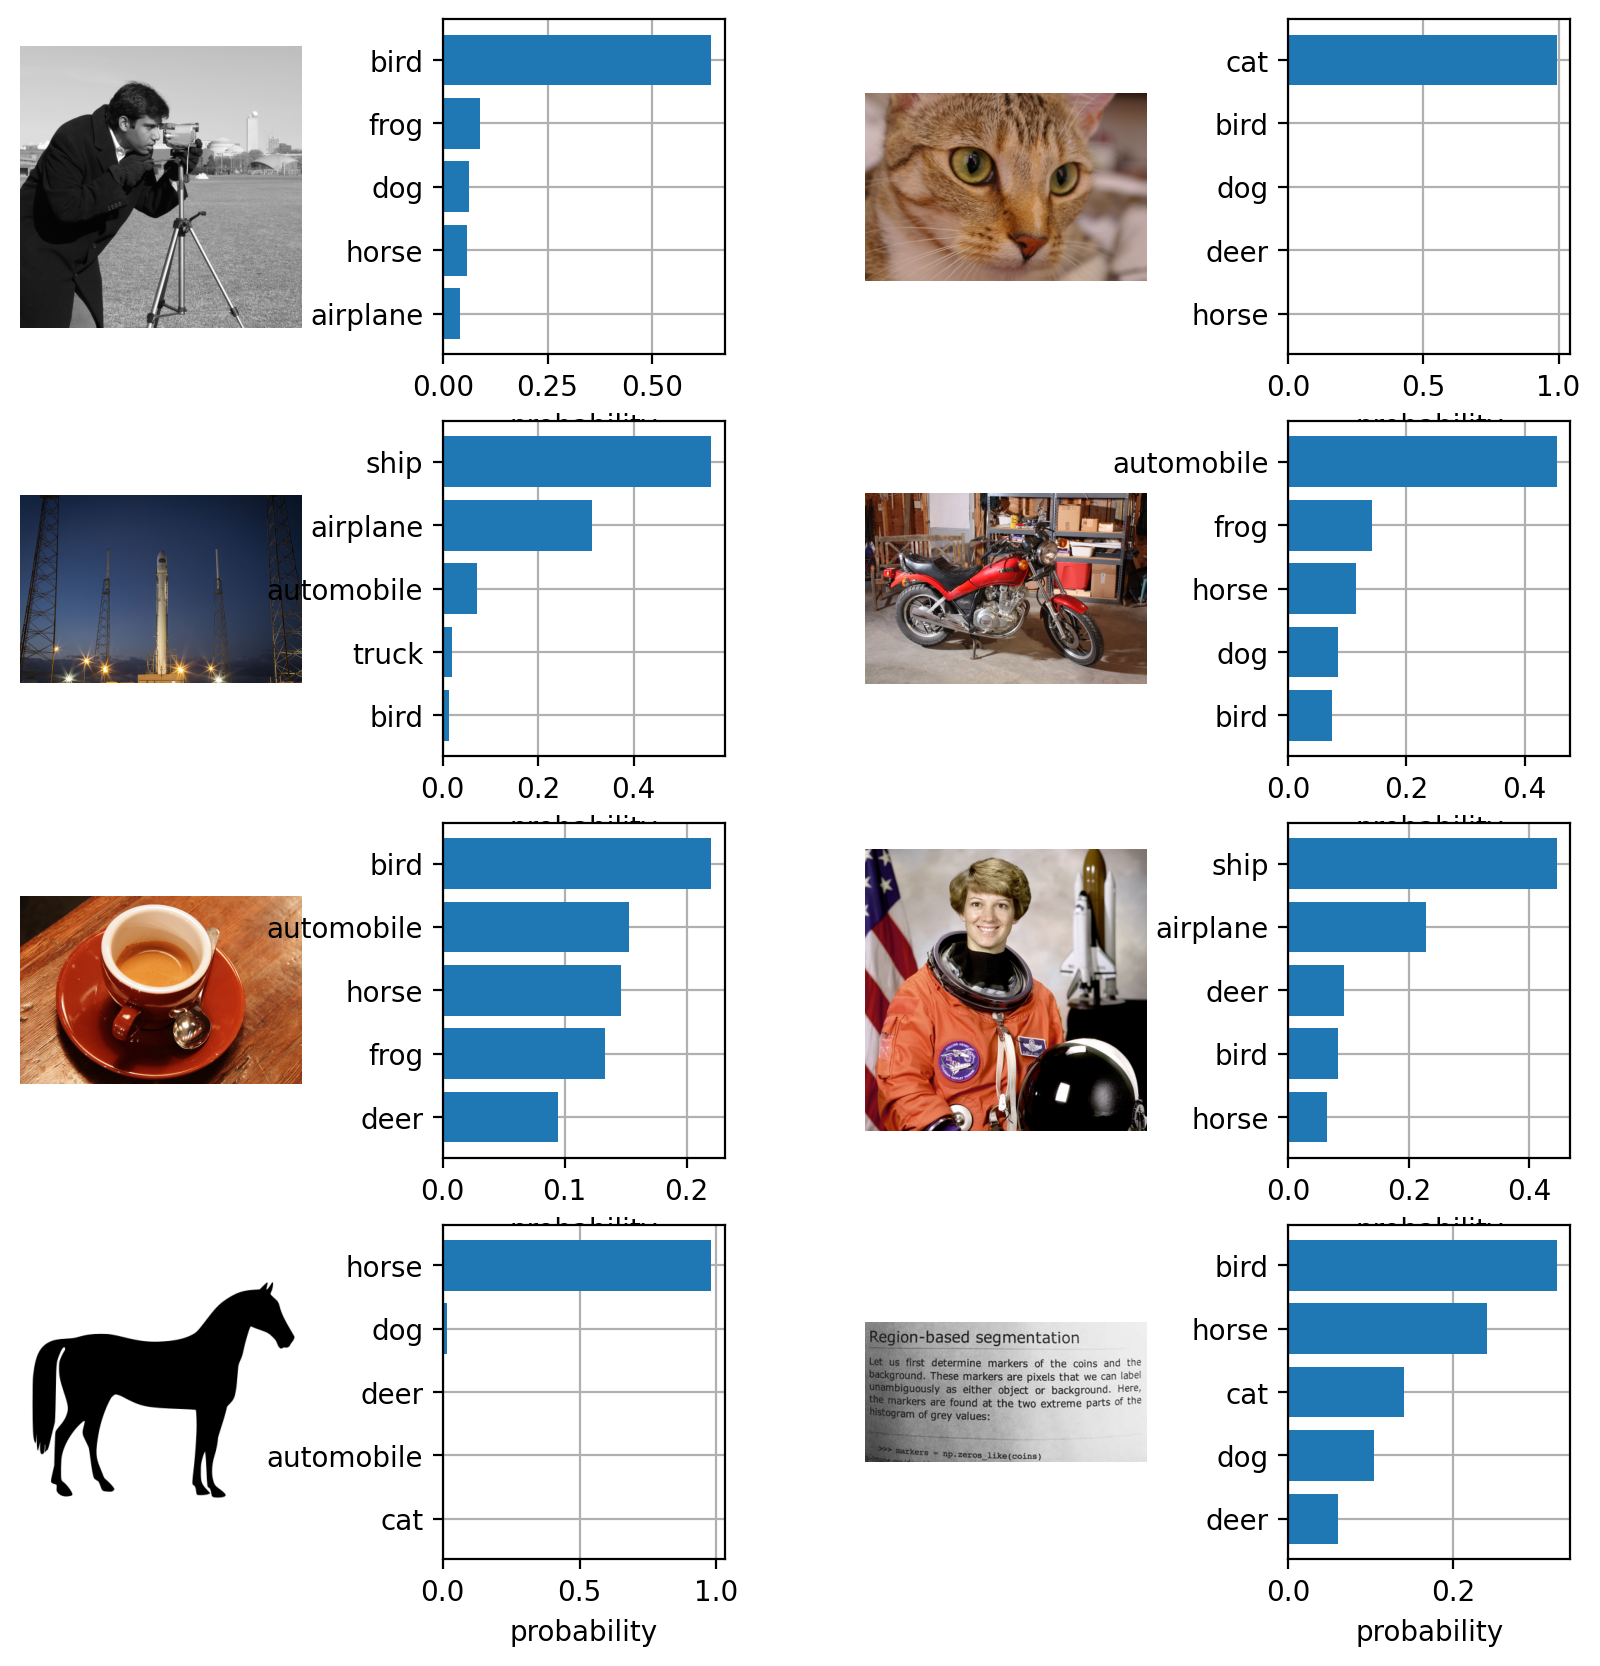

In [15]:
def embed_dataset_classnames(dataset_name: str, templates: list[str] = ["a photo of a {}."]):
  Dataset = DATASETS[dataset_name]
  # create the list of descriptions and tokenise them
  dataset = Dataset("./data", transform=preprocess, download=True, train=False)
  classnames = dataset.classes

  texts_z_views = []
  for template in templates:
    descriptions = [template.format(c) for c in classnames]
    text_tokens = clip.tokenize(descriptions).cuda()

    # get the normalised textual features
    with torch.no_grad():
        texts_z = model.encode_text(text_tokens).float()
        texts_z /= texts_z.norm(dim=-1, keepdim=True)
        texts_z_views.append(texts_z)

  # evaluate the mean representation
  texts_z = torch.stack(texts_z_views).mean(dim=0)

  # renormalise
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  return classnames, texts_z

# get the text descriptions and their embeddings
texts, texts_z = embed_dataset_classnames(
  "cifar10",
  templates=["a photo of a {}", "a low-res picture of a {}"]
)

# evalaute the softmax from the cosine similarities
similarity = cosine_similarity(texts_z, images_z)
texts_p = (100 * similarity).softmax(dim=-1)

# visualise the top-5 predictions
visualise_probabilities(images_fp, texts, texts_p, k=5)

# Finetune CLIP

Although CLIP lacks a linear layer for classifying samples, there are various ways to adapt CLIP for downstream tasks. While it's generally not recommended to completely fine-tune the entire network (as we did in the last lab with the AlexNet examples), there are several methods to adapt CLIP for transfer learning.

One straightforward solution is to add a linear layer on top of the visual features of CLIP to classify a specific dataset.

Let's consider an example with MNIST. To do this, we will reuse code from previous lab lessons.

## Setup

First, we need to modify the get_data function from the old labs to support different datasets and custom transforms (since CLIP has its own).

In [22]:
def get_data(dataset_name, batch_size=64, transform=None, test_batch_size=256):
  dataset = DATASETS[dataset_name]

  if not transform:
    # convert the PIL images to Tensors
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

  # load data
  full_training_data = dataset('./data', train=True, transform=transform, download=True)
  test_data = dataset('./data', train=False, transform=transform, download=True)

  # create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples * 0.5 + 1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, 1, shuffle=False)

  return train_loader, val_loader, test_loader

Next, we write a custom `test_step` function to evaluate how well zero-shot CLIP performs

In [24]:
def test_step_zero_shot_clip(net, data_loader, texts_z, device='cuda'):
  samples = 0.0
  cumulative_accuracy = 0.0

  # set the network to evaluation mode
  net.eval()

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # load data into GPU
      print(targets)
      
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      # these two lines are different from the "traditional" ones
      images_z = model.encode_image(inputs).float()
      outputs = (100 * images_z @ texts_z.T).softmax(dim=-1)

      # fetch prediction and loss value
      samples += inputs.shape[0]
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_accuracy / samples * 100

And we evaluate the performance of zero-shot CLIP on a dataset.

In [25]:
dataset_name = "cifar10"

_, _, test_loader = get_data(dataset_name, transform=preprocess, batch_size=128)
texts, texts_z = embed_dataset_classnames(dataset_name)
test_accuracy = test_step_zero_shot_clip(model, test_loader, texts_z)

print("Test accuracy {:.2f}".format(test_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
tensor([3])


ZeroDivisionError: float division by zero

Now, let's attempt to add a linear layer on top of the visual encoder of CLIP and see if we can enhance performance.

The initial step is to create a custom neural network that builds upon the visual encoder.

In [ ]:
class CustomCLIP(torch.nn.Module):
  def __init__(self, num_classes: int = 10):
    super().__init__()
    model, _ = clip.load("RN50")

    # take the visual encoder of CLIP
    # we also convert it to be 32 bit (by default CLIP is 16)
    self.encoder = model.visual.float()

    # add a linear layer
    self.classifier = torch.nn.Linear(1024, num_classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.classifier(x)

    return x

Next, we can define the other components of training, such as the optimizer, the loss function, and the training and testing steps.

In [ ]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD([
      {'params': model.classifier.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)

  return optimizer

In [ ]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [ ]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to training mode
  net.train()

  # iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # forward pass
    outputs = net(inputs)

    # loss computation
    loss = cost_function(outputs, targets)

    # backward pass
    loss.backward()

    # parameters update
    optimizer.step()

    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

def test_step(net, data_loader, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # set the network to evaluation mode
  net.eval()

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():
    # iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      outputs = net(inputs)

      # loss computation
      loss = cost_function(outputs, targets)

      # fetch prediction and loss value
      samples += inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

## Put it all together!

We need a compact procedure to apply all the components and functions defined so far into the actual optimization procedure. In particular, we want our model to iterate over training step and test step for multiple epochs, tracking the partial results.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

# main funcition
def main(
      dataset_name="cifar10",
      batch_size=128,
      num_classes=10,
      device='cuda:0',
      learning_rate=0.01,
      weight_decay=0.000001,
      momentum=0.9,
      epochs=10,
    ):
  # create a logger for the experiment
  writer = SummaryWriter(log_dir="runs/exp1")

  # get dataloaders
  train_loader, val_loader, test_loader = get_data(
    dataset_name, transform=preprocess, batch_size=batch_size,
  )

  # instantiate the network and move it to the chosen device (GPU)
  net = CustomCLIP(num_classes=num_classes).to(device)

  # instantiate the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  # define the cost function
  cost_function = get_cost_function()

  # computes evaluation results before training
  print('Before training:')
  train_loss, train_accuracy = test_step(net, train_loader, cost_function)
  val_loss, val_accuracy = test_step(net, val_loader, cost_function)
  test_loss, test_accuracy = test_step(net, test_loader, cost_function)

  # log to TensorBoard
  log_values(writer, -1, train_loss, train_accuracy, "train")
  log_values(writer, -1, val_loss, val_accuracy, "validation")
  log_values(writer, -1, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # for each epoch, train the network and then compute evaluation results
  for e in range(epochs):

    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function)

    # logs to TensorBoard
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  # compute final evaluation results
  print('After training:')
  train_loss, train_accuracy = test_step(net, train_loader, cost_function)
  val_loss, val_accuracy = test_step(net, val_loader, cost_function)
  test_loss, test_accuracy = test_step(net, test_loader, cost_function)

  # log to TensorBoard
  log_values(writer, epochs, train_loss, train_accuracy, "train")
  log_values(writer, epochs, val_loss, val_accuracy, "validation")
  log_values(writer, epochs, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # closes the logger
  writer.close()

## Run it!

In [ ]:
!rm -r runs

In [ ]:
main()

Files already downloaded and verified
Files already downloaded and verified
Before training:
	Training loss 0.01811, Training accuracy 7.48
	Validation loss 0.00906, Validation accuracy 8.00
	Test loss 0.00924, Test accuracy 7.78
-----------------------------------------------------
Epoch: 1
	Training loss 0.01747, Training accuracy 35.29
	Validation loss 0.00843, Validation accuracy 44.58
-----------------------------------------------------
Epoch: 2
	Training loss 0.01634, Training accuracy 47.17
	Validation loss 0.00792, Validation accuracy 47.57
-----------------------------------------------------
Epoch: 3
	Training loss 0.01543, Training accuracy 49.49
	Validation loss 0.00752, Validation accuracy 51.11
-----------------------------------------------------
Epoch: 4
	Training loss 0.01470, Training accuracy 51.32
	Validation loss 0.00720, Validation accuracy 51.21
-----------------------------------------------------
Epoch: 5
	Training loss 0.01410, Training accuracy 52.30
	Valida

## Bottom line

Although training a linear layer on top of the visual encoder of CLIP may yield good results, this implementation sacrifices the zero-shot capability of CLIP by removing the textual encoder from the pipeline. Is there an implementation that allows for finetuning CLIP for a downstream task while preserving the textual encoder for classification?

What if we introduce a bottleneck at the end of the visual encoder instead of using a linear layer?

An example architecture could be:

```python
class BottleneckCLIP(torch.nn.Module):
  def __init__(self, bias=False):
    super().__init__()
    model, _ = clip.load("RN50")
    in_features = 1024
    out_features = 1024

    # take the visual encoder of CLIP
    # we also convert it to be 32 bit (by default CLIP is 16)
    self.encoder = model.visual.float()

    # add a bottleneck
    self.bottleneck = torch.nn.Sequential([
      torch.nn.Linear(in_features, in_features // 2, bias=bias),
      torch.nn.ReLU(inplace=True),
      torch.nn.Linear(in_features // 2, in_features // 2, bias=bias),
      torch.nn.ReLU(inplace=True),
      torch.nn.Linear(in_features // 2, out_features, bias=bias),
    ])
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.bottleneck(x)

    return x
```

There appear to be numerous methods for finetuning CLIP. Can you suggest some other approaches? For example, instead of solely finetuning the visual representation of images, could we focus on enhancing the textual aspect of CLIP?

# Bootstrapping Language-Image Pre-training (BLIP)

Another recent example of a foundation model for language and vision is BLIP [2]. While it draws inspiration from CLIP, its training objective differs slightly and its capabilities vary from those of CLIP, such as VQA and captioning.

## Setup

Let's start by first installing the relevant libraries.

In [ ]:
!pip install salesforce-lavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We can now import all the pertinent packages.

In [ ]:
import lavis

Additionally, we will load a sample image to demonstrate BLIP's functionalities in the upcoming sections of the notebook.

![](https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg)

In [ ]:
import locale

import gdown

locale.getpreferredencoding = lambda: "UTF-8" # fix utf-8 issue

gdown.download('https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg', output='image.jpg')
image = Image.open("image.jpg").convert("RGB")

Downloading...
From: https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg
To: /content/image.jpg
100%|██████████| 3.95M/3.95M [00:00<00:00, 28.1MB/s]


## Image captioning

With BLIP, you can perform the same image-text reasoning as we did with CLIP, but we also have access to new functionalities. One of these is image captioning, which allows us to generate a textual description for a given input image.

To enable this feature, we need to load the model and a sample image.

In [ ]:
model, image_preprocess, _ = lavis.models.load_model_and_preprocess(
  name="blip_caption", model_type="large_coco", is_eval=True, device='cuda'
)

Similar to CLIP, the loading function also includes some preprocessing transformations to format the inputs. However, in this case, the function provides us with 3 values instead of 2 because it also includes preprocessing transformations for the textual input.

Furthermore, if we print the `image_preprocess` object, we can see that it is a dictionary that contains a set of transformations for both training and evaluation of the model.

In [ ]:
print(image_preprocess.keys())
print(image_preprocess['train'].transform)
print(image_preprocess['eval'].transform)

dict_keys(['train', 'eval'])
Compose(
    RandomResizedCrop(size=(384, 384), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Compose(
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


To test the captioning model, we need to preprocess the image and input it into the model.

In [ ]:
input_image = image_preprocess["eval"](image).unsqueeze(0).cuda()
captions = model.generate({"image": input_image}, use_nucleus_sampling=True, num_captions=3)
captions

['an old and ornate building lit up in the evening',
 'an old building with people walking around in the background',
 'an old structure that is outside at night']

## Text localization

Another application of BLIP is to localize a specific caption within an image. This is useful for understanding how the model reacts to different inputs and providing insight into what the network perceives in the scene.

To accomplish this, we need to instantiate a different model, but the overall pipeline is straightforward.

In [ ]:
model, image_preprocess, text_preprocess = lavis.models.load_model_and_preprocess(
  "blip_image_text_matching", "large", is_eval=True, device='cuda'
)

First, we need to prepare the input image and input text. We can reuse one of the outputs of the captioning model for the text.

In [ ]:
input_image = image_preprocess["eval"](image).unsqueeze(0).cuda()
input_text = text_preprocess["eval"](captions[0])

Next, we can visualize the GradCAM output on the input image.

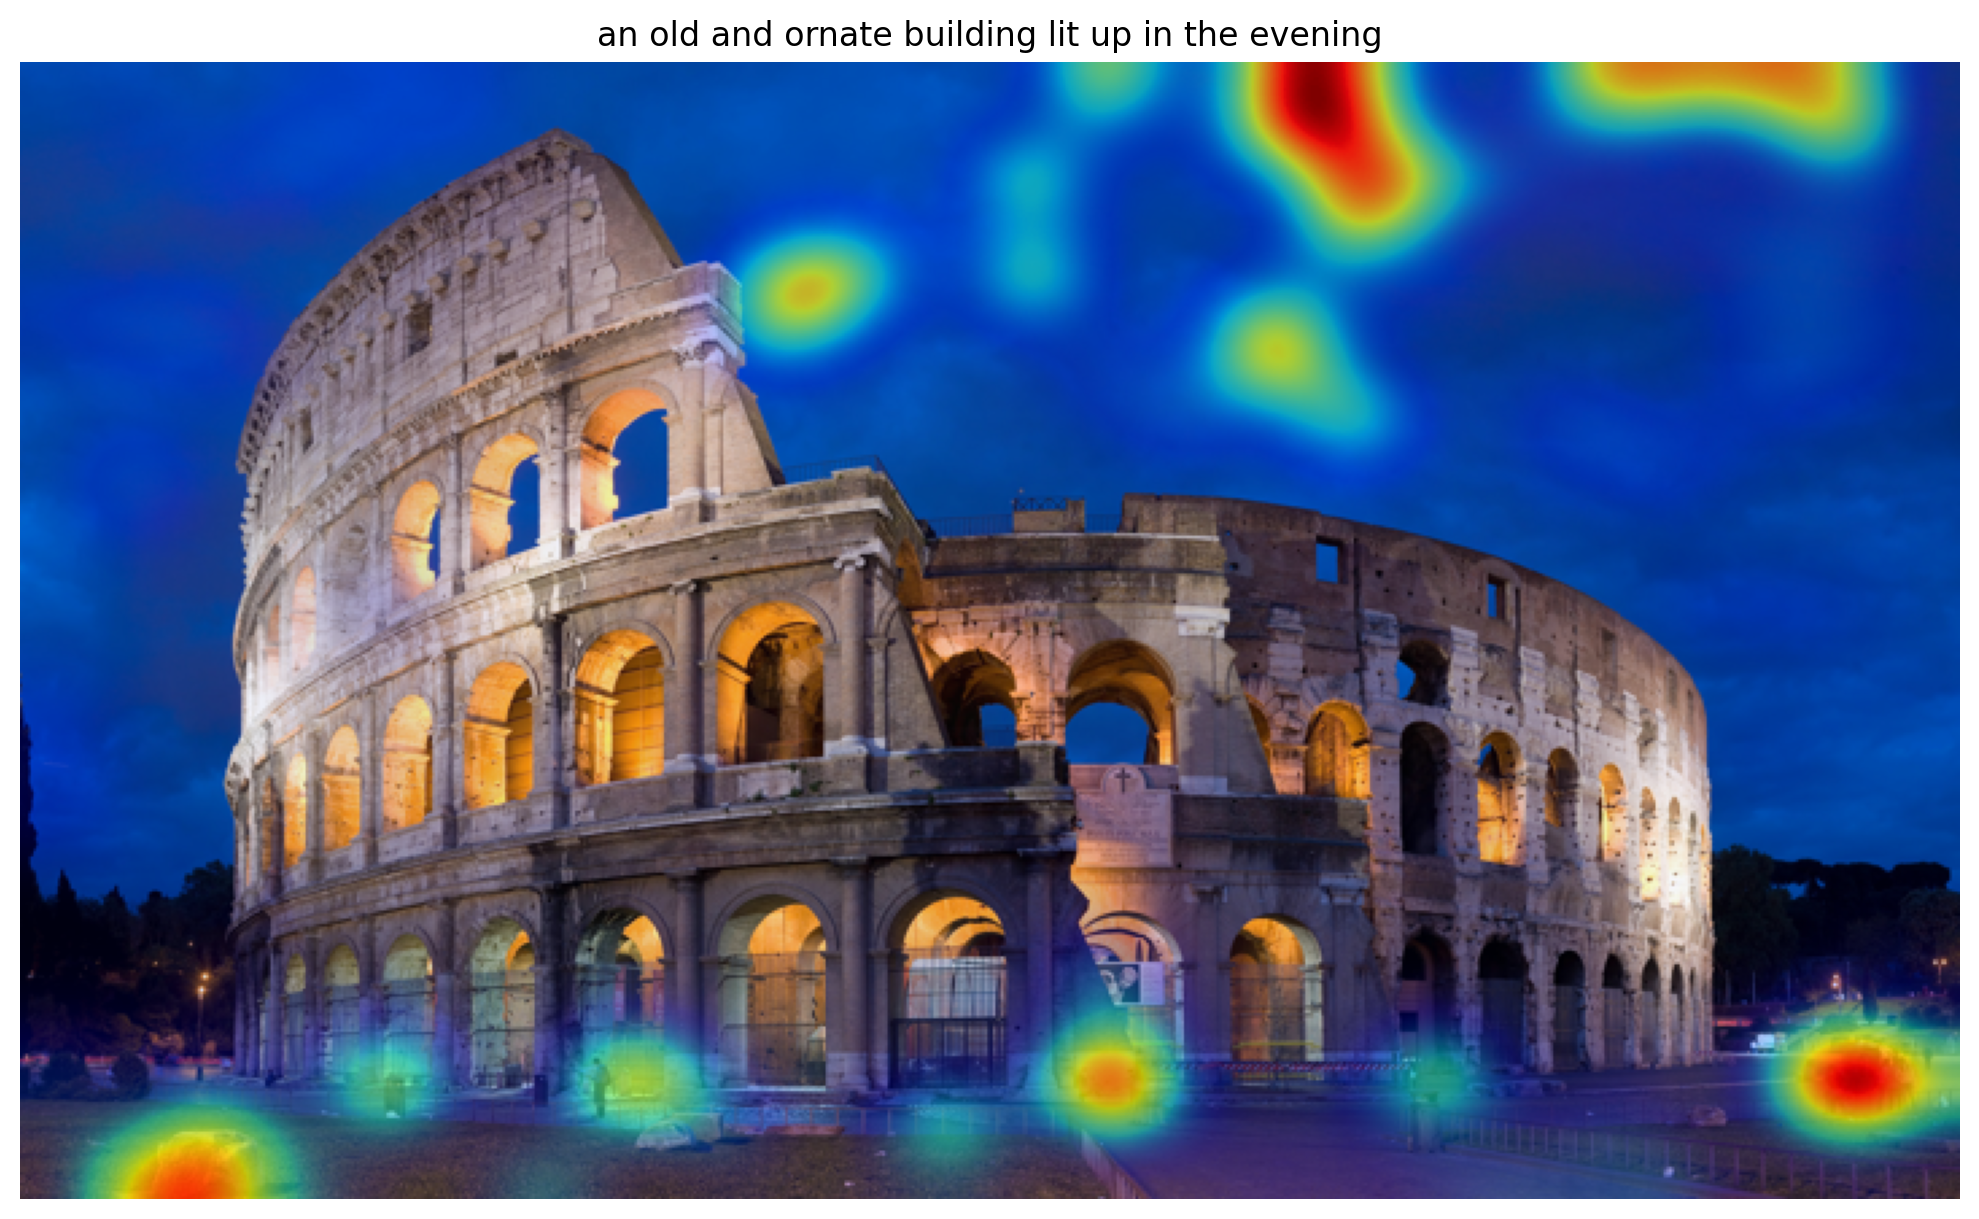

In [ ]:
import matplotlib.pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam


def rescale_image(image: Image, target_width: int = 720):
  w, h = image.size
  scale = target_width / w
  image = image.resize((int(w * scale), int(h * scale)))

  return image

def visualise_gradcam(
  gradcam, image: Image, text_tokens: torch.Tensor = None, average: bool = True, image_target_width: int = 720
):
  image = rescale_image(image, target_width=image_target_width)
  image_norm = np.float32(image) / 255

  if average:
    # get the average gradcap
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)

    # plot gradcam
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(captions[0])
    ax.imshow(gradcam)
    ax.axis('off')
    fig.tight_layout()
  else:
    # get the number of images from the number of tokens
    num_image = len(text_tokens.input_ids[0]) - 2

    # create the image
    fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

    # create the iterators
    gradcam_iter = iter(gradcam[0][2:-1])
    token_id_iter = iter(text_tokens.input_ids[0][1:-1])

    # plot an ax for each token
    for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
      word = model.tokenizer.decode([token_id])
      gradcam_image = getAttMap(image_norm, gradcam, blur=True)
      ax[i].imshow(gradcam_image)
      ax[i].set_yticks([])
      ax[i].set_xticks([])
      ax[i].set_xlabel(word)

# tokenize text
text_tokens = model.tokenizer(input_text, return_tensors="pt").to('cuda')

# evaluate the gradcam
gradcam, _ = compute_gradcam(
  model, input_image, input_text, text_tokens, block_num=7
)

# visualise the gradcam
visualise_gradcam(gradcam, image, text_tokens=text_tokens, average=True)

## Visual Question Answering

The final application of BLIP is VQA, which involves answering a question about an input image. To accomplish this, we follow the same pipeline as the previous two examples. We first load the model and prepare the inputs, and then test BLIP on the task.

In [ ]:
model, image_preprocess, text_preprocess = lavis.models.load_model_and_preprocess(
  name="blip_vqa", model_type="vqav2", is_eval=True, device='cuda'
)

In [ ]:
question = "In which city is this building?"

input_image = image_preprocess["eval"](image).unsqueeze(0).cuda()
input_text = text_preprocess["eval"](question)

samples = {"image": input_image, "text_input": input_text}

Now that we have prepared the inputs, we can ask the model a question and receive an answer.

In [ ]:
model.predict_answers(samples=samples, inference_method="generate")

['rome']

It is worth noting that we can also provide a list of possible options to the model for it to select the best candidate from.

In [ ]:
model.predict_answers(samples, answer_list=['naples', 'rome', 'perugia'], inference_method="rank")

['rome']

# References

1. Radford, Alec, et al. "Learning transferable visual models from natural language supervision." International conference on machine learning. PMLR, 2021.
2. Li, Junnan, et al. "Blip: Bootstrapping language-image pre-training for unified vision-language understanding and generation." International Conference on Machine Learning. PMLR, 2022.